In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../../Train.csv')

# Display the first few rows to check for a column that might indicate holidays
print(df.head())


             date_time is_holiday  air_pollution_index  humidity  wind_speed  \
0  2012-10-02 09:00:00       None                  121        89           2   
1  2012-10-02 10:00:00       None                  178        67           3   
2  2012-10-02 11:00:00       None                  113        66           3   
3  2012-10-02 12:00:00       None                   20        66           3   
4  2012-10-02 13:00:00       None                  281        65           3   

   wind_direction  visibility_in_miles  dew_point  temperature  rain_p_h  \
0             329                    1          1       288.28       0.0   
1             330                    1          1       289.36       0.0   
2             329                    2          2       289.58       0.0   
3             329                    5          5       290.13       0.0   
4             329                    7          7       291.14       0.0   

   snow_p_h  clouds_all weather_type weather_description  traf

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../../Train.csv')

# Check unique values in the 'is_holiday' column
print(df['is_holiday'].unique())

# Convert any value that is not 'None' to 1 (indicating a holiday) and 'None' to 0
df['is_holiday'] = df['is_holiday'].apply(lambda x: 0 if x == 'None' else 1)

# Verify the conversion
print(df['is_holiday'].value_counts())


['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']
0    33707
1       43
Name: is_holiday, dtype: int64


In [3]:
# Group by the 'is_holiday' column and calculate average traffic volume
average_traffic_by_holiday = df.groupby('is_holiday')['traffic_volume'].mean()
print(average_traffic_by_holiday)

is_holiday
0    3243.182395
1     838.116279
Name: traffic_volume, dtype: float64


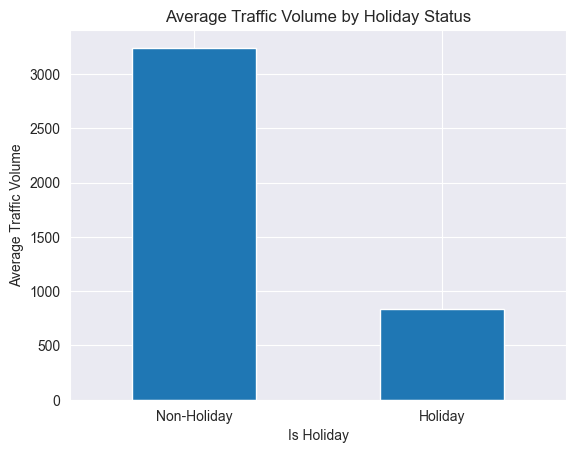

In [4]:
import matplotlib.pyplot as plt

# Plot average traffic volume by holiday status
average_traffic_by_holiday.plot(kind='bar')
plt.title('Average Traffic Volume by Holiday Status')
plt.xlabel('Is Holiday')
plt.ylabel('Average Traffic Volume')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.show()

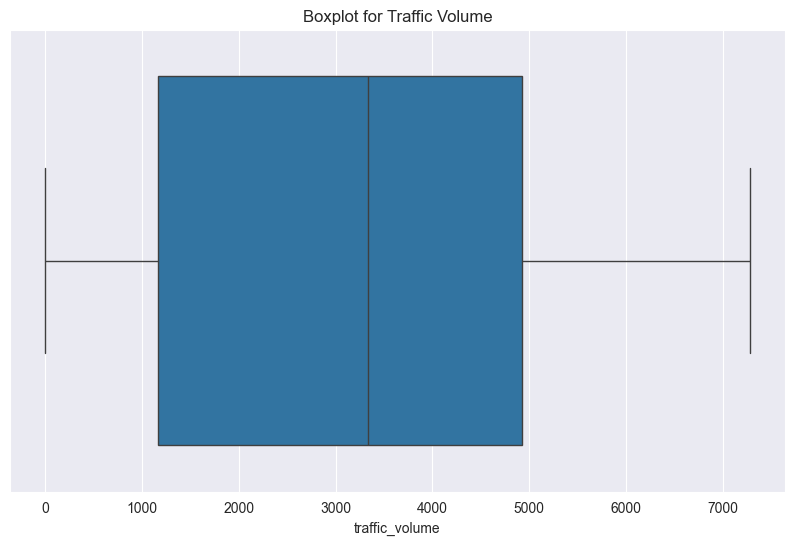

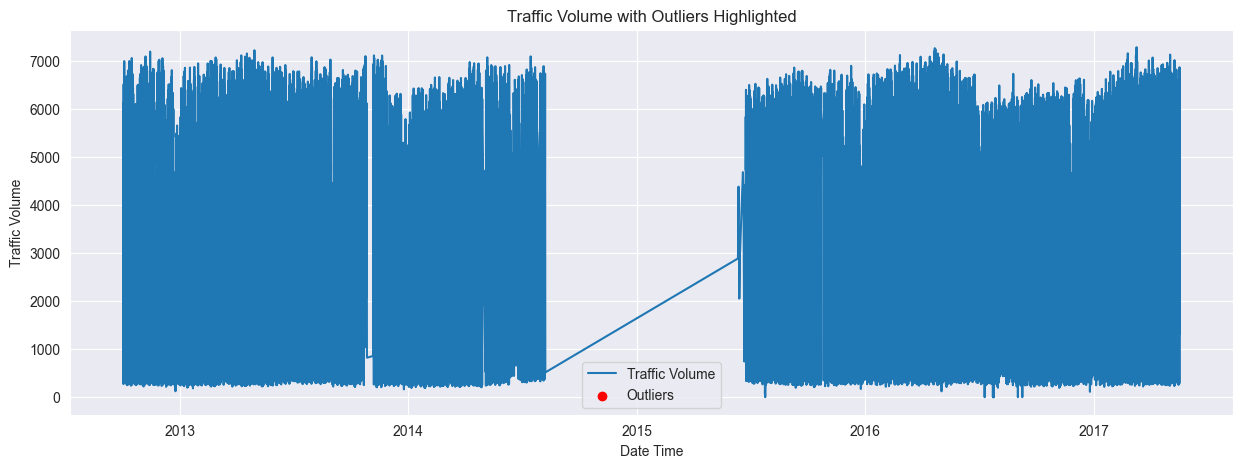

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_raw = pd.read_csv('../../Train.csv')
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Drop rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Calculate IQR for outlier detection
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as those outside of Q1 - 1.5*IQR and Q3 + 1.5*IQR
outliers = df[(df[target] < (Q1 - 1.5 * IQR)) | (df[target] > (Q3 + 1.5 * IQR))]

# Plot to visualize outliers using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df[target])
plt.title('Boxplot for Traffic Volume')
plt.show()

# Plot a time series graph highlighting outliers
plt.figure(figsize=(15, 5))
plt.plot(df.index, df[target], label='Traffic Volume')
plt.scatter(outliers.index, outliers[target], color='red', label='Outliers', zorder=5)
plt.title('Traffic Volume with Outliers Highlighted')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import joblib
        
# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Make scorers from custom scoring functions
mape = make_scorer(mape_scorer, greater_is_better=False)

# Load the dataset
df_raw = pd.read_csv('../../Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)

end_of_A = '2014-08-08 01:00:00'
df_period_A = df_raw[df_raw['date_time'] <= end_of_A]

# Extracting non-numeric columns
non_numeric_cols = ['is_holiday', 'weather_type', 'weather_description']

# Group by 'date_time' and aggregate
agg_funcs = {col: 'mean' for col in df_period_A.columns if col not in non_numeric_cols}
agg_funcs.update({col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in non_numeric_cols})
df_aggregated = df_period_A.groupby('date_time').agg(agg_funcs)

# One-hot encode categorical features
df = pd.get_dummies(df_aggregated, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Add hour from the 'date_time' column
df['hour'] = df.index.hour

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Save 'date_time' for later use
date_time = df['date_time']

# Drop 'date_time' column before scaling
df = df.drop(columns=['date_time'])

# Scale the numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Convert scaled data back to DataFrame and add 'date_time' column back
df_scaled = pd.DataFrame(df_scaled, columns=[col for col in df.columns if col != 'date_time'])
df_scaled['date_time'] = date_time.values

joblib.dump(scaler, 'scaler.joblib')

# Split the data into train and test sets
total_samples = df_scaled.shape[0]
split_index = int(total_samples * 0.9)

X_train = df_scaled.iloc[:split_index].drop(columns=['date_time'])
y_train = y.iloc[:split_index]
X_test = df_scaled.iloc[split_index:].drop(columns=['date_time'])
y_test = y.iloc[split_index:]

X_train = X_train.drop(target, axis=1)
X_test = X_test.drop(target, axis=1)

svr_model = SVR()

# Define the parameter distributions for RandomizedSearchCV, adapted for SVR
param_grid  = {
    'C': np.linspace(0.1, 1, 2),  # Reduce the number of C values
    'gamma': ['scale', 'auto'] + list(np.linspace(0.001, 0.1, 3)),  # Further reduce the number of gamma values
    'epsilon': np.linspace(0.01, 0.1, 3),  # Further reduce the number of epsilon values
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Update the scoring parameter with a dictionary of metrics
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': mape
}

# Create a TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the TqdmRandomizedSearchCV object with the time series cross-validator for SVR
grid_search_svr = GridSearchCV(
    estimator=svr_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='RMSE',
    cv=tscv,
    verbose=1
)

# Fit the random search to the scaled data for SVR
grid_search_svr.fit(X_train, y_train)

# Get the best parameters for SVR
best_parameters_svr = grid_search_svr.best_params_
print(f"Best parameters for SVR found: {best_parameters_svr}")

# Save the best SVR model
best_model_svr = grid_search_svr.best_estimator_
joblib.dump(best_model_svr, 'Full_Grid_best_svr_model.joblib')

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for SVR found: {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


['Full_Grid_best_svr_model.joblib']

In [7]:
# Evaluate metrics on the training set
y_train_pred = best_model_svr.predict(X_train)
train_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'MSE': mean_squared_error(y_train, y_train_pred),
    'MAE': mean_absolute_error(y_train, y_train_pred),
    'MAPE': mape_scorer(y_train, y_train_pred)
}

# Evaluate metrics on the validation set
y_val_pred = best_model_svr.predict(X_test)
val_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_val_pred)),
    'MSE': mean_squared_error(y_test, y_val_pred),
    'MAE': mean_absolute_error(y_test, y_val_pred),
    'MAPE': mape_scorer(y_test, y_val_pred)
}

# Print and compare metrics
print("Training Set Metrics:")
print(train_metrics)

print("\nValidation Set Metrics:")
print(val_metrics)

Training Set Metrics:
{'RMSE': 849.1554936327763, 'MSE': 721065.0523667239, 'MAE': 573.7170589482358, 'MAPE': 29.13756765966604}

Validation Set Metrics:
{'RMSE': 949.8967273558752, 'MSE': 902303.792641402, 'MAE': 607.6390996437387, 'MAPE': 28.246041622100627}


In [8]:
df

,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,...,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light drizzle,weather_description_thunderstorm with light rain,weather_description_very heavy rain,hour,traffic_volume_lag_1,traffic_volume_lag_2,traffic_volume_lag_3,traffic_volume_rolling_mean,traffic_volume_rolling_std
date_time,,,,,,,,,,,,,,,,,,,,,
2012-10-02 12:00:00,20.0,66.0,3.0,329.0,5.0,5.0,290.13,0.0,0.0,90.0,...,0,0,0,0,12,4767.0,4516.0,5545.0,4942.666667,536.520581
2012-10-02 13:00:00,281.0,65.0,3.0,329.0,7.0,7.0,291.14,0.0,0.0,75.0,...,0,0,0,0,13,5026.0,4767.0,4516.0,4769.666667,255.010457
2012-10-02 14:00:00,23.0,65.0,3.0,328.0,6.0,6.0,291.72,0.0,0.0,1.0,...,0,0,0,0,14,4918.0,5026.0,4767.0,4903.666667,130.093556
2012-10-02 15:00:00,184.0,64.0,3.0,328.0,7.0,7.0,293.17,0.0,0.0,1.0,...,0,0,0,0,15,5181.0,4918.0,5026.0,5041.666667,132.198084
2012-10-02 16:00:00,167.0,64.0,3.0,327.0,7.0,7.0,293.86,0.0,0.0,1.0,...,0,0,0,0,16,5584.0,5181.0,4918.0,5227.666667,335.443488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-07 21:00:00,30.0,75.0,3.0,333.0,6.0,6.0,295.46,0.0,0.0,1.0,...,0,0,0,0,21,3441.0,3826.0,5121.0,4129.333333,880.118363
2014-08-07 22:00:00,160.0,72.0,3.0,337.0,5.0,5.0,294.69,0.0,0.0,1.0,...,0,0,0,0,22,3274.0,3441.0,3826.0,3513.666667,283.083615
2014-08-07 23:00:00,120.0,70.0,3.0,335.0,3.0,3.0,294.48,0.0,0.0,90.0,...,0,0,0,0,23,2479.0,3274.0,3441.0,3064.666667,514.029506


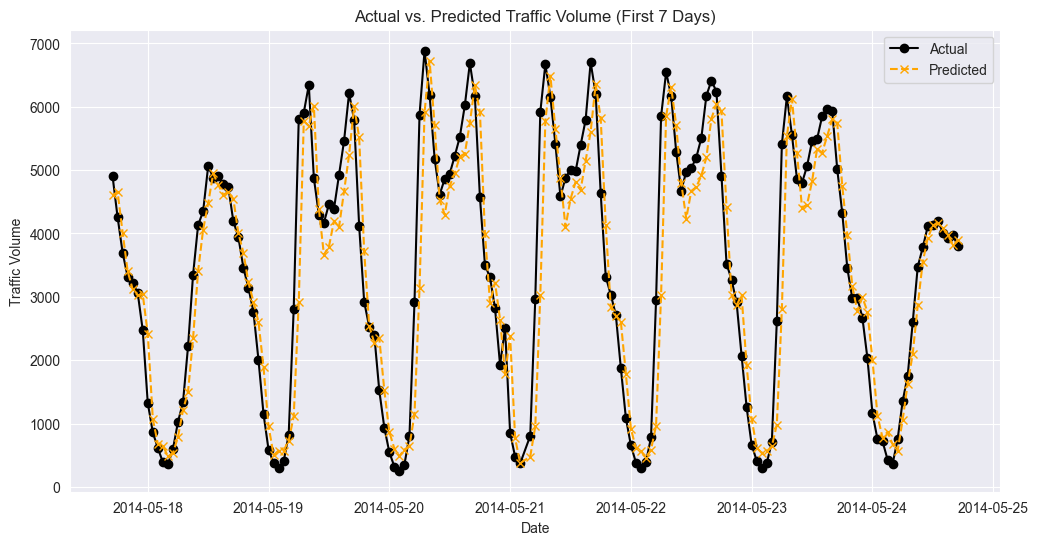

In [9]:
# Plot the actual vs. predicted traffic volume for the first 7 days
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:168], y_test.iloc[:168], label='Actual', marker='o', linestyle='-', color='black')
plt.plot(y_test.index[:168], y_val_pred[:168], label='Predicted', marker='x', linestyle='--', color='orange')
plt.title('Actual vs. Predicted Traffic Volume (First 7 Days)')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

In [10]:
df = pd.concat([date_time, df], axis=1)

In [11]:
# Function to update the lagged features with the new prediction
def update_lagged_features(df, new_prediction, max_lags=3):
    for i in range(max_lags-1, 0, -1):
        df[f'traffic_volume_lag_{i+1}'] = df[f'traffic_volume_lag_{i}']
    df['traffic_volume_lag_1'] = new_prediction

# Initialize DataFrame for dynamic forecasting
df_dynamic_forecast = X_test.copy()
df_dynamic_forecast['forecasted_traffic_volume'] = np.nan

# Number of steps to forecast
forecast_steps = 720

for i in range(forecast_steps):
    # Predict the traffic volume for the next time step
    current_prediction = best_model_svr.predict(df_dynamic_forecast.iloc[i:i+1].drop(columns=['forecasted_traffic_volume']))[0]
    df_dynamic_forecast.at[df_dynamic_forecast.index[i], 'forecasted_traffic_volume'] = current_prediction

    # Update lagged features with the new prediction for the next iteration
    if i + 1 < forecast_steps:
        update_lagged_features(df_dynamic_forecast.iloc[i + 1], current_prediction)

C:\Users\Nadim Pramono\AppData\Local\Temp\ipykernel_15300\3297971007.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'traffic_volume_lag_{i+1}'] = df[f'traffic_volume_lag_{i}']
C:\Users\Nadim Pramono\AppData\Local\Temp\ipykernel_15300\3297971007.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['traffic_volume_lag_1'] = new_prediction
C:\Users\Nadim Pramono\AppData\Local\Temp\ipykernel_15300\3297971007.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [12]:
# Initialize the DataFrame
test_date_times = df['date_time'][split_index:].reset_index(drop=True)

df_result = pd.DataFrame({
    'date_time': test_date_times,
    'actual_traffic_volume': y_test.reset_index(drop=True),
    'lag_1': np.nan,
    'lag_2': np.nan,
    'lag_3': np.nan,
    'forecasted_traffic_volume': df_dynamic_forecast['forecasted_traffic_volume'].reset_index(drop=True)
})

# Set the initial lagged values from the historical data
df_result.loc[0, 'lag_1'] = df.loc[df.index[split_index - 1], 'traffic_volume']
df_result.loc[0, 'lag_2'] = df.loc[df.index[split_index - 2], 'traffic_volume']
df_result.loc[0, 'lag_3'] = df.loc[df.index[split_index - 3], 'traffic_volume']

# Update the lagged values with the forecasted values in each step
for i in range(1, len(df_result)):
    df_result.loc[i, 'lag_1'] = df_result.loc[i - 1, 'forecasted_traffic_volume']
    df_result.loc[i, 'lag_2'] = df_result.loc[i - 1, 'lag_1']
    df_result.loc[i, 'lag_3'] = df_result.loc[i - 1, 'lag_2']

# Display the DataFrame
print(df_result.head(forecast_steps))

              date_time  actual_traffic_volume        lag_1        lag_2  \
0   2014-05-17 17:00:00                 4906.0  4893.000000  5028.000000   
1   2014-05-17 18:00:00                 4258.0  4599.830370  4893.000000   
2   2014-05-17 19:00:00                 3699.0  4660.070152  4599.830370   
3   2014-05-17 20:00:00                 3317.0  4014.227809  4660.070152   
4   2014-05-17 21:00:00                 3226.0  3404.785551  4014.227809   
..                  ...                    ...          ...          ...   
715 2014-07-05 04:00:00                  319.0  2829.925741  3541.456642   
716 2014-07-05 05:00:00                  623.0  1299.003129  2829.925741   
717 2014-07-05 06:00:00                 1118.0   222.724116  1299.003129   
718 2014-07-05 07:00:00                 1452.0   713.425202   222.724116   
719 2014-07-05 08:00:00                 2019.0  1383.011257   713.425202   

           lag_3  forecasted_traffic_volume  
0    5308.000000                4599.8303

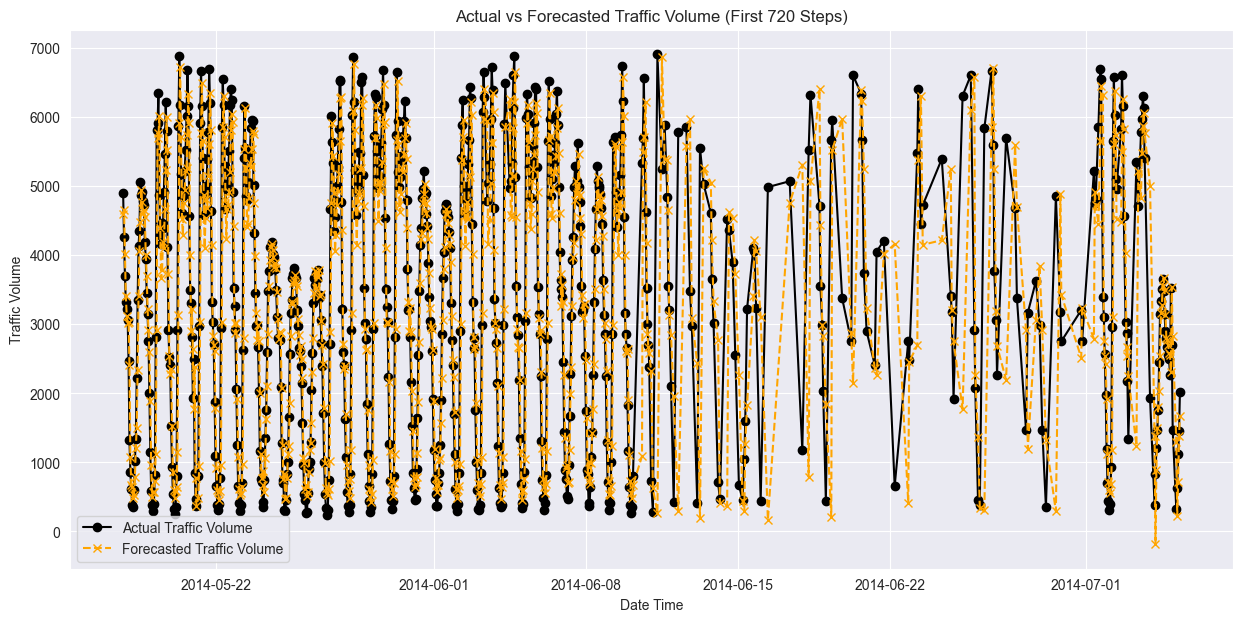

In [13]:
import matplotlib.pyplot as plt

# Select the steps for plotting
df_plot = df_result.head(forecast_steps)

# Plotting the actual vs. forecasted traffic volumes
plt.figure(figsize=(15, 7))
plt.plot(df_plot['date_time'], df_plot['actual_traffic_volume'], label='Actual Traffic Volume', color='black', marker='o')
plt.plot(df_plot['date_time'], df_plot['forecasted_traffic_volume'], label='Forecasted Traffic Volume', color='orange', linestyle='--', marker='x')

# Adding labels and title
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.title('Actual vs Forecasted Traffic Volume (First 720 Steps)')
plt.legend()

# Display the plot
plt.show()

In [14]:
df_result.tail()

,date_time,actual_traffic_volume,lag_1,lag_2,lag_3,forecasted_traffic_volume
1385,2014-08-07 21:00:00,3274.0,NaN,NaN,NaN,NaN
1386,2014-08-07 22:00:00,2479.0,NaN,NaN,NaN,NaN
1387,2014-08-07 23:00:00,1491.0,NaN,NaN,NaN,NaN
1388,2014-08-08 00:00:00,848.0,NaN,NaN,NaN,NaN
1389,2014-08-08 01:00:00,516.0,NaN,NaN,NaN,NaN


In [15]:
df_result.dropna(inplace=True)

In [16]:
actual_values = df_result['actual_traffic_volume']
new_forecasted_values = df_result['forecasted_traffic_volume']

# Evaluate metrics on the training set
y_train_pred_grid = best_model_svr.predict(X_train)
train_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_grid)),
    'MSE': mean_squared_error(y_train, y_train_pred_grid),
    'MAE': mean_absolute_error(y_train, y_train_pred_grid),
    'MAPE': mape_scorer(y_train, y_train_pred_grid),
    'R2': r2_score(y_train, y_train_pred_grid)  # R2 score for training set
}

# Calculate the metrics for forecasted values
forecast_metrics = {
    'RMSE': np.sqrt(mean_squared_error(actual_values, new_forecasted_values)),
    'MSE': mean_squared_error(actual_values, new_forecasted_values),
    'MAE': mean_absolute_error(actual_values, new_forecasted_values),
    'MAPE': mape_scorer(actual_values, new_forecasted_values),
    'R2': r2_score(actual_values, new_forecasted_values)  # R2 score for forecast
}

# Print the metrics
print("\nMetrics for Train Values:")
print(train_metrics_grid)
print("\nMetrics for Forecasted Values:")
print(forecast_metrics)



Metrics for Train Values:
{'RMSE': 849.1554936327763, 'MSE': 721065.0523667239, 'MAE': 573.7170589482358, 'MAPE': 29.13756765966604, 'R2': 0.8221042402784061}

Metrics for Forecasted Values:
{'RMSE': 1086.6586773914632, 'MSE': 1180827.0811501641, 'MAE': 670.9389418334722, 'MAPE': 32.56931313003611, 'R2': 0.7035478565690172}


In [17]:
print(X_train.columns)

Index(['air_pollution_index', 'humidity', 'wind_speed', 'wind_direction',
       'visibility_in_miles', 'dew_point', 'temperature', 'rain_p_h',
       'snow_p_h', 'clouds_all', 'is_holiday_Columbus Day',
       'is_holiday_Independence Day', 'is_holiday_Labor Day',
       'is_holiday_Martin Luther King Jr Day', 'is_holiday_Memorial Day',
       'is_holiday_New Years Day', 'is_holiday_None', 'is_holiday_State Fair',
       'is_holiday_Thanksgiving Day', 'is_holiday_Veterans Day',
       'is_holiday_Washingtons Birthday', 'weather_type_Clouds',
       'weather_type_Drizzle', 'weather_type_Fog', 'weather_type_Haze',
       'weather_type_Mist', 'weather_type_Rain', 'weather_type_Snow',
       'weather_type_Squall', 'weather_type_Thunderstorm',
       'weather_description_Sky is Clear', 'weather_description_broken clouds',
       'weather_description_drizzle', 'weather_description_few clouds',
       'weather_description_fog', 'weather_description_haze',
       'weather_description_heavy in